In [1]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
def make_matrix(ase_table, value_column):
    mat = (
        ase_table[["sampleID", "gene", value_column]]
        .set_index(["sampleID", "gene"])
        .unstack()
    )
    mat.columns = mat.columns.get_level_values(1)
    return mat

In [2]:
from scipy.stats import fisher_exact
fisher_exact()

In [62]:
def ASE_compare_survival(gene, ase_table, survival_table,  return_stats=False,expression_table=None,plot=False,stratify_expression=None):
    """Wrapper function for sksurv kaplan_meier_estimator and 
    compare_survival that uses log-rank test to compares survival
    between samples showing ASE and BAE. Optionally, compare 
    survival between ASE + high expression and BAE + low expression
    or vice versa.
    
    Parameters
    ----------
    gene: gene to compute survival difference for
    
    ase_table: DataFrame
        Dataframe where each row represents one gene in one sample, with
        a column 'ase' indicating that the gene shows ASE (1) or BAE (0). 
        Required columns: 'gene','ase','sampleID'
    
    survival_table: DataFrame
        Dataframe of survival time and survival status for each sample.
        Index must be the sampleID. Required columns: 'survival_time',
        'survival_status'
    return_stats: bool, default: False
        Return summary from sksurv compare_survival function.
    stratify_expression: {'ase high', 'ase low', 'None'}, default: None
        Set to further stratify samples into ASE + high expression and 
        BAE + low expression or vice versa.
    
    expression_table: DataFrame
        Required if stratify_expression is set. A dataframe where rows are
        samples and columns are genes, with expression values for each gene.
        Index must be the sampleID.
    
    plot: bool, default: False
        Set to plot Kaplan-Meier curve with p-value
    
    Returns
    -------
    chisq: float
        Test statistic.
    pvalue: float
        Two-sided p-value with respect to the null hypothesis
        that the hazard rates across all groups are equal.
    stats: pandas.DataFrame
        Summary statistics for each group:  number of samples,
        observed number of events, expected number of events,
        and test statistic.
        Only provided if `return_stats` is True.
    covariance: array, shape=(n_groups, n_groups)
        Covariance matrix of the test statistic.
        Only provided if `return_stats` is True.

    list of Line2D:
        Only if plot=True. A list of lines representing the plotted data
        from matplotlib
    """
    
    ase_mat = make_matrix(ase_table,'ase')
    if (ase_mat[gene] == 1).any() == False:
        raise Exception("No samples show ASE for input gene")
    if stratify_expression==None:
        if len(ase_mat.index) != len(survival_table.index):
            raise Exception("Unequal number of Sample IDs in tables")
        elif set(ase_mat.index) != set(survival_table.index):
            raise Exception("Sample IDs of tables do not match")
        elif gene not in set(ase_mat.columns):
            raise Exception("Input gene not found")
    else: # check if expression table meet criteria 
        if expression_table is None:
            raise ValueError("Expression table must be passed if stratify_expression is set")
        if len(ase_mat.index) != len(expression_table.index):
            raise Exception("Unequal number of Sample IDs in tables")
        elif set(ase_mat.index) != set(expression_table.index):
            raise Exception("Sample IDs of tables do not match")
        
    # Get samples showing ase and bae 
    ase_id = ase_mat[(ase_mat[gene] ==1)].index
    bae_id = ase_mat[ase_mat[gene]==0].index
    
    # Get survival time for ase and bae samples
    ase_vals = survival_table.loc[ase_id, "survival_time"].astype(float).dropna()
    bae_vals = survival_table.loc[bae_id, "survival_time"].astype(float).dropna()
    
    if stratify_expression==None:
        groups = pd.concat([pd.Series(index=bae_vals.index,data="BAE"), pd.Series(index=ase_vals.index,data="ASE")])
        label_ase='ASE'
        label_bae='BAE'
    else:
        # Get expr vals for pats with ase data
        expression_table = expression_table[(expression_table.index.isin(ase_vals.index)) | (expression_table.index.isin(bae_vals.index))]
    
        if stratify_expression=="ase high":
            # Get samples with high expression and ase
            # then samples with low expression and bae
            high = expression_table[(expression_table.index.isin(ase_id)) & (expression_table[gene] > expression_table[gene].median())].index
            low = expression_table[(expression_table.index.isin(bae_id)) & (expression_table[gene] <= expression_table[gene].median())].index

            # subset the survival vals
            ase_vals = ase_vals[ase_vals.index.isin(high)]
            bae_vals = bae_vals[bae_vals.index.isin(low)]

            label_ase ="ASE and high expression"
            label_bae ="BAE and low expression"
        elif stratify_expression=="ase low":
            # Get samples with high expression and bae
            # then samples with low expression and ase
            high = expression_table[(expression_table.index.isin(bae_id)) & (expression_table[gene] > expression_table[gene].median())].index
            low = expression_table[(expression_table.index.isin(ase_id)) & (expression_table[gene] <= expression_table[gene].median())].index

            ase_vals = ase_vals[ase_vals.index.isin(low)]
            bae_vals = bae_vals[bae_vals.index.isin(high)]

            label_ase ="ASE and low expression"
            label_bae ="BAE and high expression"

        high_group = pd.Series(index=high,data="high")
        low_group = pd.Series(index=low,data="low")   
        groups = pd.concat([low_group, high_group])

    time_treatment_ase, survival_prob_treatment_ase = kaplan_meier_estimator(
           survival_table.loc[ase_vals.index, "survival_status"] == "event",
            ase_vals)

    time_treatment_bae, survival_prob_treatment_bae = kaplan_meier_estimator(
            survival_table.loc[bae_vals.index,  "survival_status"] == "event",
            bae_vals)
    
    event_ind = survival_table.loc[list(bae_vals.index) + list(ase_vals.index), "survival_status"] == "event"
    time_to = pd.concat([bae_vals,ase_vals])
    
    dt=np.dtype('bool,float')
    strarray = np.array(list(zip(event_ind,time_to)),dtype=dt)
    
    if plot: # Plot kaplan meier plot
        pvalue=compare_survival(y=strarray, group_indicator=groups)[1]
        plt.figure(figsize=(4,3.5),dpi=150)
        plt.step(time_treatment_ase, survival_prob_treatment_ase, where="post",
                     label= label_ase, color = "firebrick", linestyle='dashed')    
        plt.step(time_treatment_bae, survival_prob_treatment_bae, where="post",
                     label=label_bae, color = "slateblue")

        plt.ylabel("Survival")
        plt.xlabel("Time")
        plt.ylim(0,1.1)
        plt.legend(loc='lower left',title=gene,fontsize=8)
        
        # label pvalue
        plt.text(0, 1.12, "p = " + str(round(pvalue,4)))

    else:
        return compare_survival(
                    y=strarray, group_indicator=groups, return_stats=return_stats)
 

In [82]:
import scipy
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

def ASE_compare_expression(gene, ase_table, expression_table, alternative='two-sided'):
    """Wrapper function for scipy.stats.mannwhitneyu to test expression
    difference between samples showing ASE and BAE using the Mann-Whitney
    U test
    
    Parameters
    ----------
    gene: gene to compute expression difference for
    
    ase_table: DataFrame
        Dataframe where each row represents one gene in one sample, with
        a column 'ase' indicating that the gene shows ASE (1) or BAE (0). 
        Required columns: 'gene','ase','sampleID'
    
    expression_table: DataFrame
        A dataframe where rows are samples and columns are genes, with 
        expression values for each gene. Index must be the sampleID.
    
    alternative: {'two-sided', 'less', 'greater'}, Default: two-sided
        'Greater' tests whether ASE distribution is greater than BAE
        distribution. 'Less' tests whether ASE distribution is less 
        than BAE distribution. 
        
    Returns
    -------

    """
    ase_mat = make_matrix(ase_table,'ase')
    
    # Make sure tables have the same sampleIDs
    if len(ase_mat.index) != len(expression_table.index):
            raise Exception("Unequal number of Sample IDs in tables")
    elif set(ase_mat.index) != set(expression_table.index):
        raise Exception("Sample IDs of tables do not match")
            
    bae = ase_mat.loc[ase_mat[gene] == 0, gene].index
    ase = ase_mat.loc[ase_mat[gene] == 1, gene].index

    if len(bae) == 0:
        raise Exception("No samples showing BAE")
    elif len(ase) == 0:
        raise Exception("No samples showing ASE")
        
    return scipy.stats.mannwhitneyu(x=expression_table.loc[expression_table.index.isin(ase),gene].dropna(),
                             y=expression_table.loc[expression_table.index.isin(bae),gene].dropna(),
                             alternative=alternative)


In [120]:
def ase_compare_groups(ase_table, group1_ids, group2_ids,testable_fraction=0.10):
    """Function to test for enrichment of ASE for all genes
    with alellic data in two different sample groups. Example: 
    tumor subtype A vs tumor subtype B, normal samples vs 
    tumor samples, etc
    
    Parameters
    ----------
    ase_table: DataFrame
        Dataframe where each row represents one gene in one sample, with
        a column 'ase' indicating 1 for ASE and 0 for BAE. Required columns:
        'gene','ase','sampleID'
    
    testable_fraction: float, default: 0.10
        Minimum fraction of samples in each group that must be testable
        for each gene
        
    group1_ids: array-like
        SampleIDs in comparison group 1
        
    group2_ids: array-like
        SampleIDs in comparison group 2
        
    Returns
    -------
    fisher_table
        Table of counts and results of fisher's exact test for each gene
    """
    if (len(group1_ids) == 0 | len(group2_ids) == 0):
        raise Exception("One or more groups is empty")
    
    mat1 = ase_table[ase_table['sampleID'].isin(group1_ids)]
    mat2 = ase_table[ase_table['sampleID'].isin(group2_ids)]
    
    if (len(mat1)==0 | len(mat2)==0):
        raise Exception("group1 ids or group2 ids were not found in ASE table")
        
    # Get minimum # of samples testable in each group
    mat1_min = len(set(mat1['sampleID']))*testable_fraction
    mat2_min = len(set(mat2['sampleID']))*testable_fraction
    
    mat1_genes = mat1['gene'].value_counts()
    mat1_genes =mat1_genes[mat1_genes >= mat1_min].index
    mat1 = mat1[mat1['gene'].isin(mat1_genes)]
    
    mat2_genes = mat2['gene'].value_counts()
    mat2_genes =mat2_genes[mat2_genes >= mat2_min].index
    mat2 = mat2[mat2['gene'].isin(mat2_genes)]
        
    mat1_sig = mat1[(mat1['ase'] ==1)]
    mat2_sig = mat2[(mat2['ase'] ==1)]

    print("mat1 genes showing ASE: ",len(set(mat1_sig['gene'])))
    print("mat1 total genes: ",len(set(mat1['gene'])))
    print("mat2 genes showing ASE: ",len(set(mat2_sig['gene'])))
    print("mat2 total genes: ",len(set(mat2['gene'])))
    
    # common genes between group 1 and 2 that are testable in  
    # testable_fraction for each group. 
    common_ASE = list(set(mat1_genes).intersection(set(mat2_genes)))
    
    # Genes with at least 1 ASE in either group that are testable in both.
    # This will be the search space for association testing
    common_ASE_sig_mat1 = [x for x in set(mat1_sig['gene']) if x in common_ASE]
    common_ASE_sig_mat2 = [x for x in set(mat2_sig['gene']) if x in common_ASE]
    genes_to_test = set(common_ASE_sig_mat1 + common_ASE_sig_mat2)
    print("testing " + str(len(genes_to_test)) + " genes")
    
    
    # Contingency table will look like:
    #         ASE       BAE
    # group1     8        2
    # group2     1        5
    
    total_mat1 = mat1['gene'].value_counts().loc[genes_to_test]
    total_mat2 = mat2['gene'].value_counts().loc[genes_to_test]
    sig_mat1 = mat1_sig['gene'].value_counts().loc[common_ASE_sig_mat1]
    sig_mat2 = mat2_sig['gene'].value_counts().loc[common_ASE_sig_mat2]
    fisher_table = pd.concat([sig_mat1,total_mat1,sig_mat2,total_mat2],join= 'outer',axis=1)
    fisher_table.columns = ['group1_ASE','group1_total','group2_ASE', 'group2_total']
    fisher_table.fillna(0, inplace=True)
    fisher_table['group1_BAE'] = fisher_table['group1_total'] - fisher_table['group1_ASE']
    fisher_table['group2_BAE'] = fisher_table['group2_total'] - fisher_table['group2_ASE']

    # Run fisher exact test on each gene, getting p-value and odds ratio
    fisher_table['odds_ratio'] = fisher_table.apply(
        lambda row: fisher_exact([[row['group1_ASE'], row['group1_BAE']], [row['group2_ASE'], row['group2_BAE']]])[0],
        axis = 1)
    fisher_table['p_val'] = fisher_table.apply(
        lambda row: fisher_exact([[row['group1_ASE'], row['group1_BAE']], [row['group2_ASE'], row['group2_BAE']]])[1],
        axis = 1)

    # Correct p-values using benjamini-hochberg
    fisher_table['FDR'] = multipletests(fisher_table['p_val'], method='fdr_bh')[1]  # the 2nd element is the actual padjs
    
    return fisher_table


In [121]:
!python --version

Python 3.9.5


In [102]:
test = [1,2,3]
test1=[1,2,3,4]

[i in test for i in test]

False

In [89]:
# excel file of fusion info for tcga patients
fusion = pd.ExcelFile("/wynton/home/rotation/mtsui/ASE_project/tcga_prad_clinical_data/mmc2.xlsx")
#fusion = pd.ExcelFile("/Users/mtsui1/Documents/huang_li_labs/ASE_project/tcga_prad_clinical_data/mmc2.xlsx")
calls = fusion.parse('Final fusion call set', header=1)
# subset to prad
calls = calls[calls['Cancer'] == "PRAD"]
calls['Sample'] = (["-".join(i.split("-")[:4]) for i in calls['Sample']])
tmprss2erg = calls[(calls['Fusion'] == 'TMPRSS2--ERG') | (calls['Fusion'] == 'ERG--TMPRSS2')]
fusion_positive = list(tmprss2erg['Sample'])
fusion_positive = [i[:-4] for i in fusion_positive]

fusion_positive 

['TCGA-EJ-7793',
 'TCGA-EJ-A65D',
 'TCGA-HC-7747',
 'TCGA-J4-A67S',
 'TCGA-V1-A8WS',
 'TCGA-2A-A8VL',
 'TCGA-2A-A8VT',
 'TCGA-2A-A8VV',
 'TCGA-2A-AAYU',
 'TCGA-4L-AA1F',
 'TCGA-CH-5739',
 'TCGA-CH-5740',
 'TCGA-CH-5741',
 'TCGA-CH-5743',
 'TCGA-CH-5744',
 'TCGA-CH-5746',
 'TCGA-CH-5752',
 'TCGA-CH-5754',
 'TCGA-CH-5764',
 'TCGA-CH-5765',
 'TCGA-CH-5768',
 'TCGA-CH-5769',
 'TCGA-CH-5789',
 'TCGA-CH-5790',
 'TCGA-CH-5791',
 'TCGA-CH-5794',
 'TCGA-EJ-5495',
 'TCGA-EJ-5496',
 'TCGA-EJ-5497',
 'TCGA-EJ-5498',
 'TCGA-EJ-5499',
 'TCGA-EJ-5502',
 'TCGA-EJ-5503',
 'TCGA-EJ-5506',
 'TCGA-EJ-5507',
 'TCGA-EJ-5508',
 'TCGA-EJ-5512',
 'TCGA-EJ-5516',
 'TCGA-EJ-5521',
 'TCGA-EJ-5522',
 'TCGA-EJ-5524',
 'TCGA-EJ-5525',
 'TCGA-EJ-5526',
 'TCGA-EJ-5527',
 'TCGA-EJ-5530',
 'TCGA-EJ-5542',
 'TCGA-EJ-7315',
 'TCGA-EJ-7321',
 'TCGA-EJ-7325',
 'TCGA-EJ-7327',
 'TCGA-EJ-7328',
 'TCGA-EJ-7783',
 'TCGA-EJ-7784',
 'TCGA-EJ-7785',
 'TCGA-EJ-7793',
 'TCGA-EJ-7797',
 'TCGA-EJ-8469',
 'TCGA-EJ-8472',
 'TCGA-EJ-A46D

In [105]:
# test, TMPRSS2 ERG
no_fusion = set(ASE.loc[~ASE['sampleID'].isin(fusion_positive),'sampleID'])

In [107]:
len(no_fusion)

307

In [118]:
df[df['FDR'] < 0.05]

,group1_ASE,group1_total,group2_ASE,group2_total,group1_BAE,group2_BAE,odds_ratio,p_val,FDR
FAM135A,40.0,124,22.0,181,84.0,159.0,3.441558,2.384679e-05,3.463508e-02
GPR116,19.0,93,3.0,127,74.0,124.0,10.612613,1.264033e-05,2.294853e-02
KRT19,2.0,91,28.0,145,89.0,117.0,0.093900,4.184902e-05,4.341537e-02
HLA-DMB,31.0,82,10.0,130,51.0,120.0,7.294118,1.721949e-07,4.168265e-04
CLSTN3,10.0,45,0.0,73,35.0,73.0,inf,3.273498e-05,3.962023e-02
ERG,27.0,33,7.0,38,6.0,31.0,19.928571,7.991252e-08,2.901624e-04
TMPRSS2,54.0,67,43.0,178,13.0,135.0,13.041145,8.139474e-16,5.910886e-12


In [119]:
df = fisher_exact_mae(ase_table=ASE,group1_ids=[], group2_ids=[])

Exception: One or more groups is empty

In [85]:
ASE_compare_expression(gene='ERG', ase_table=ASE, expression_table=tpm)

MannwhitneyuResult(statistic=1109.0, pvalue=3.406318002616005e-08)

## Load data

In [4]:
clinical = pd.read_csv("../../tcga_prad_clinical_data/data_bcr_clinical_data_patient.txt", sep="\t", comment='#',index_col="PATIENT_ID")
good_col = ['HISTOLOGICAL_DIAGNOSIS',
       'HISTOLOGICAL_SUBTYPE', 'PRIMARY_SITE_PATIENT',
       'GLEASON_PATTERN_PRIMARY', 'GLEASON_PATTERN_SECONDARY', 'GLEASON_SCORE',
       'GLEASON_PATTERN_TERTIARY', 'LATERALITY', 'TUMOR_LEVEL', 
       'PROSPECTIVE_COLLECTION', 'RETROSPECTIVE_COLLECTION',
       'HISTORY_OTHER_MALIGNANCY', 
       'BONE_SCAN_RESULT', 'CT_SCAN_AB_PELVIS_INDICATOR',
       'CT_SCAN_AB_PELVIS_RESULTS', 'MRI_RESULTS', 'RESIDUAL_TUMOR', 'TUMOR_STATUS',
       'PSA_MOST_RECENT_RESULTS',
       'BIOCHEMICAL_RECURRENCE_INDICATOR', 'RADIATION_TREATMENT_ADJUVANT',
       'TREATMENT_OUTCOME_FIRST_COURSE',
       'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT',
       'DAYS_TO_BIOCHEMICAL_RECURRENCE_FIRST', 'AGE',
       'CLIN_T_STAGE',  'ICD_O_3_HISTOLOGY',  'INITIAL_PATHOLOGIC_DIAGNOSIS_METHOD',
       'PATH_N_STAGE', 'PATH_T_STAGE', 
       'TARGETED_MOLECULAR_THERAPY',
       'TISSUE_SOURCE_SITE',  'OS_STATUS', 'OS_MONTHS',
       'DFS_STATUS', 'DFS_MONTHS']
##### Data cleaning ######
# subset to columns with sufficient data
good_col = ['GLEASON_SCORE', 'TUMOR_STATUS','OS_STATUS', 'OS_MONTHS','DFS_STATUS', 'DFS_MONTHS','GLEASON_PATTERN_PRIMARY','GLEASON_PATTERN_SECONDARY']
clinical = clinical[good_col]

# Read in race column since this table didn't have sufficient data
race = pd.read_csv("/wynton/home/rotation/mtsui/ASE_project/PRAD RACE TCGA 492.csv", header=None, index_col = 0, names=["RACE", "TYPE"])
race = race[race["RACE"] != "ethnicity"]
clinical = clinical.merge(race["RACE"], how = "left", left_index=True, right_index = True)

# Read in progression free survival
pfs = pd.read_csv("../../tcga_prad_clinical_data/KM_Plot__Progression_Free__Survival_(months).txt", header=0, sep='\t', index_col = "Patient ID")
clinical = clinical.merge(pfs[["PFS_MONTHS","PFS_STATUS"]], how = "left", left_index=True, right_index = True)


clinical["GLEASON_SCORE_binary"] = ["low" if x < 7 else "high" for x in clinical['GLEASON_SCORE']]
# Gleason 6-7 (only 3+4 for 7) are low, gleason 7 (4+3) and 8+ is high
clinical.loc[(clinical['GLEASON_PATTERN_PRIMARY'] == 3) & (clinical['GLEASON_PATTERN_SECONDARY'] == 4),'GLEASON_SCORE_binary'] = "low"
# Change any [Not available] etc to NaN
clinical.replace(to_replace="^\[.*\]$", value=np.NaN, regex=True, inplace=True)
clinical

,GLEASON_SCORE,TUMOR_STATUS,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS,GLEASON_PATTERN_PRIMARY,GLEASON_PATTERN_SECONDARY,RACE,PFS_MONTHS,PFS_STATUS,GLEASON_SCORE_binary
PATIENT_ID,,,,,,,,,,,,
TCGA-2A-A8VL,6,TUMOR FREE,0:LIVING,20.40,0:DiseaseFree,20.40,3,3,SAS,20.416215,0:CENSORED,low
TCGA-2A-A8VO,6,TUMOR FREE,0:LIVING,55.88,0:DiseaseFree,55.88,3,3,EUR,55.922675,0:CENSORED,low
TCGA-2A-A8VT,9,NaN,0:LIVING,45.11,0:DiseaseFree,45.11,4,5,SAS,45.139231,0:CENSORED,high
TCGA-2A-A8VV,6,TUMOR FREE,0:LIVING,22.04,0:DiseaseFree,22.04,3,3,AFR,22.060032,0:CENSORED,low
TCGA-2A-A8VX,8,TUMOR FREE,0:LIVING,45.27,0:DiseaseFree,45.27,4,4,EUR,45.303613,0:CENSORED,high
...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZG-A9M4,9,WITH TUMOR,0:LIVING,17.97,0:DiseaseFree,17.97,5,4,EUR,17.983365,0:CENSORED,high
TCGA-ZG-A9MC,9,WITH TUMOR,0:LIVING,14.95,0:DiseaseFree,14.95,5,4,EUR,14.958740,0:CENSORED,high
TCGA-ZG-A9N3,9,WITH TUMOR,0:LIVING,11.47,0:DiseaseFree,11.47,5,4,EUR,11.473847,0:CENSORED,high


In [5]:
clinical = clinical[['PFS_MONTHS','PFS_STATUS']]
clinical.columns = ['survival_time',	'survival_status']
clinical.loc[clinical['survival_status'] == '0:CENSORED', 'survival_status'] = "censored"
clinical.loc[clinical['survival_status'] == '1:PROGRESSION', 'survival_status'] ="event"
#clinical.dropna(inplace=True)

/wynton/home/rotation/mtsui/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [6]:
# Read in genes with ASE data.
# Subset to significant genes, p-adj < 0.05
ASE = pd.read_feather("/wynton/home/rotation/mtsui/ASE_project/match_dna_rna/ase_rows_only_with_p.feather")

ASE

,gene,snp,mutect_ref_n,arc_ref_n,mutect_total_n,arc_total_n,foldc_adjust,caseID,dna_ref_frac,rna_ref_frac,...,snp_and_gene,caseid_snp,genename,caseid_gene,ase,ase_p,FDR,foldc_adjust_new,mae,mae_strong
0,ZYX_ENSG00000159840.14,chr7_143382967_A_T,41,119.0,92,250.0,1.127720,TCGA-ZG-A9NI-01A,0.445652,0.476000,...,chr7_143382967_A_T_ZYX,TCGA-ZG-A9NI-01A_chr7_143382967_A_T,ZYX,TCGA-ZG-A9NI-01A_ZYX,0,0.340468,0.679091,1.129678,0,0
1,ZWINT_ENSG00000122952.15,chr10_56358869_T_C,52,22.0,118,35.0,2.111111,TCGA-ZG-A9NI-01A,0.440678,0.628571,...,chr10_56358869_T_C_ZWINT,TCGA-ZG-A9NI-01A_chr10_56358869_T_C,ZWINT,TCGA-ZG-A9NI-01A_ZWINT,0,0.027331,0.160123,2.144539,0,0
2,ZRANB2_ENSG00000132485.11,chr1_71070891_G_C,30,15.0,62,28.0,1.223437,TCGA-ZG-A9NI-01A,0.483871,0.535714,...,chr1_71070891_G_C_ZRANB2,TCGA-ZG-A9NI-01A_chr1_71070891_G_C,ZRANB2,TCGA-ZG-A9NI-01A_ZRANB2,0,0.706088,0.949954,1.230258,0,0
3,ZNFX1_ENSG00000124201.13,chr20_49248972_G_A,24,5.0,56,11.0,1.122449,TCGA-ZG-A9NI-01A,0.428571,0.454545,...,chr20_49248972_G_A_ZNFX1,TCGA-ZG-A9NI-01A_chr20_49248972_G_A,ZNFX1,TCGA-ZG-A9NI-01A_ZNFX1,0,1.000000,1.000000,1.110871,0,0
4,ZNF84_ENSG00000198040.9,chr12_133041405_G_A,17,8.0,45,15.0,1.845714,TCGA-ZG-A9NI-01A,0.377778,0.533333,...,chr12_133041405_G_A_ZNF84,TCGA-ZG-A9NI-01A_chr12_133041405_G_A,ZNF84,TCGA-ZG-A9NI-01A_ZNF84,0,0.286361,0.634208,1.879898,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493003,AARS_ENSG00000090861.14,chr16_70253274_A_G,17,81.0,31,146.0,1.030971,TCGA-2A-A8VO-01A,0.548387,0.554795,...,chr16_70253274_A_G_AARS,TCGA-2A-A8VO-01A_chr16_70253274_A_G,AARS,TCGA-2A-A8VO-01A_AARS,0,0.933780,1.000000,1.026190,0,0
1493004,AAK1_ENSG00000115977.17,chr2_69514669_C_T,20,6.0,33,8.0,1.712195,TCGA-2A-A8VO-01A,0.606061,0.750000,...,chr2_69514669_C_T_AAK1,TCGA-2A-A8VO-01A_chr2_69514669_C_T,AAK1,TCGA-2A-A8VO-01A_AAK1,0,0.492619,0.827367,1.946546,0,0
1493005,AACS_ENSG00000081760.15,chr12_125076605_A_G,31,7.0,67,14.0,1.158730,TCGA-2A-A8VO-01A,0.462687,0.500000,...,chr12_125076605_A_G_AACS,TCGA-2A-A8VO-01A_chr12_125076605_A_G,AACS,TCGA-2A-A8VO-01A_AACS,0,0.795309,0.971567,1.160942,0,0
1493006,A4GALT_ENSG00000128274.14,chr22_42692965_C_T,22,21.0,48,57.0,0.693760,TCGA-2A-A8VO-01A,0.458333,0.368421,...,chr22_42692965_C_T_A4GALT,TCGA-2A-A8VO-01A_chr22_42692965_C_T,A4GALT,TCGA-2A-A8VO-01A_A4GALT,0,0.185683,0.510798,0.689941,0,0


In [7]:
ASE = ASE[['genename','ase','mae','caseID']]
ASE['caseID'] = [i[:-4] for i in ASE['caseID']]
ASE.columns=['gene','ase','mae','sampleID']
ASE

<ipython-input-7-b511842d79ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ASE['caseID'] = [i[:-4] for i in ASE['caseID']]


,gene,ase,mae,sampleID
0,ZYX,0,0,TCGA-ZG-A9NI
1,ZWINT,0,0,TCGA-ZG-A9NI
2,ZRANB2,0,0,TCGA-ZG-A9NI
3,ZNFX1,0,0,TCGA-ZG-A9NI
4,ZNF84,0,0,TCGA-ZG-A9NI
...,...,...,...,...
1493003,AARS,0,0,TCGA-2A-A8VO
1493004,AAK1,0,0,TCGA-2A-A8VO
1493005,AACS,0,0,TCGA-2A-A8VO
1493006,A4GALT,0,0,TCGA-2A-A8VO


In [8]:
# Localized
tpm = pd.read_csv("/wynton/home/rotation/mtsui/fhuang/TCGA_prad_vcfs/gene_expr/all_tcga_prad_tpm.csv",index_col = 0)
tpm = tpm.iloc[:,1:]
tpm.dropna(subset=["hgnc_symbol"], inplace = True)
tpm.drop_duplicates(subset=["hgnc_symbol"], inplace = True)
tpm.set_index("hgnc_symbol", inplace=True)
tpm = tpm.T

# Get tumor only
tpm['type'] = [any(prefix in caseID for prefix in ['11A','11B']) for caseID in tpm.index]
tpm['type'] = ['normal' if i==True else 'tumor' for i in tpm['type']]
tpm = tpm[tpm['type']=='tumor']
tpm.iloc[:,:-1] = tpm.iloc[:,:-1].apply(lambda x: np.log2(x + 1))

tpm.index = ["-".join(i.split("-")[:3]) for i in tpm.index]
tpm = tpm[~tpm.index.duplicated()]
#tpm = tpm[tpm.index.isin(set(ASE['caseID']))]
#tpm.dropna(inplace=True)
tpm

hgnc_symbol,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ELOA3BP,NPBWR1,ELOA3DP,PDCD6-AHRR,ELOA3P,LNCDAT,CDR1,ACTL10,PANO1,type
TCGA-J4-A83M,5.373008,0.169925,5.873897,3.031536,1.207081,2.353549,2.764919,5.557805,3.529846,4.928797,...,0.0,0.140517,0.0,0.0,0.0,0.000000,0.0,0.0,1.343635,tumor
TCGA-KK-A8IL,5.267925,0.471135,6.653294,3.079651,1.660107,4.003962,4.357094,5.758319,4.426124,5.298981,...,0.0,1.401740,0.0,0.0,0.0,0.000000,0.0,0.0,0.818442,tumor
TCGA-EJ-5501,5.633655,0.041383,6.238710,3.331849,1.732356,2.154713,2.772266,5.762242,4.407026,5.246005,...,0.0,0.243182,0.0,0.0,0.0,0.052833,0.0,0.0,1.479644,tumor
TCGA-VN-A88P,5.414064,0.483983,6.288034,2.770512,1.235788,2.616405,3.473852,5.766950,3.625493,4.693543,...,0.0,0.143785,0.0,0.0,0.0,0.000000,0.0,0.0,0.973134,tumor
TCGA-J4-A83K,6.065531,2.370806,6.346462,3.613708,1.585828,2.796909,2.471526,5.999132,4.151218,5.023912,...,0.0,0.176833,0.0,0.0,0.0,0.000000,0.0,0.0,0.756682,tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EJ-A8FO,6.035285,0.123799,6.610640,3.494800,1.598175,2.558145,2.838004,6.086726,4.484338,5.281928,...,0.0,0.109160,0.0,0.0,0.0,0.000000,0.0,0.0,0.739243,tumor
TCGA-YL-A8SQ,5.741939,0.629753,5.975139,3.046962,1.655993,2.399280,3.456938,5.716503,4.014061,5.243433,...,0.0,0.852878,0.0,0.0,0.0,0.000000,0.0,0.0,1.006980,tumor
TCGA-2A-A8VX,5.969116,0.055335,5.826322,2.838589,0.939753,1.029064,1.709467,5.907124,3.578576,4.257267,...,0.0,0.318230,0.0,0.0,0.0,0.000000,0.0,0.0,0.920674,tumor
TCGA-G9-6366,5.659111,0.530271,5.965888,3.031907,1.036538,1.548437,1.748204,6.378591,4.063270,4.475675,...,0.0,0.208892,0.0,0.0,0.0,0.057416,0.0,0.0,1.002595,tumor


In [9]:
commonid = set(ASE['sampleID']) & set(clinical.index) &set(tpm.index) 
ASE = ASE[ASE['sampleID'].isin(commonid)]
clinical = clinical.loc[commonid]
tpm = tpm.loc[commonid]

In [18]:
# Test plotting stratified by ASE and expression
ASE_compare_survival("DNAH8", ase_table=ASE, survival_table=clinical, expression_table=tpm, stratify_expression = "ase low", plot=False,return_stats=True)

(2.787608951020281,
 0.09499587477358365,
        counts  observed   expected  statistic
 group                                        
 high       42        14   9.879863   4.120137
 low        69        13  17.120137  -4.120137,
 array([[ 6.08963667, -6.08963667],
        [-6.08963667,  6.08963667]]))

Text(0, 0.5, 'hello')

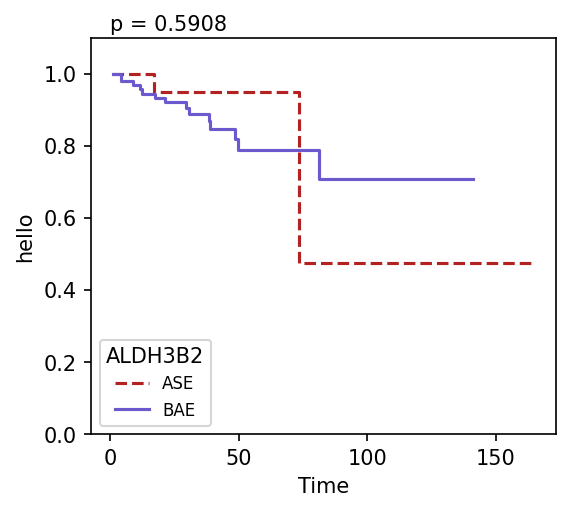

In [64]:
# Test plotting stratified by ASE and expression
ASE_compare_survival("ALDH3B2", ase_table=ASE, survival_table=clinical, plot=True,return_stats=False)


In [57]:
plt.show(fig)

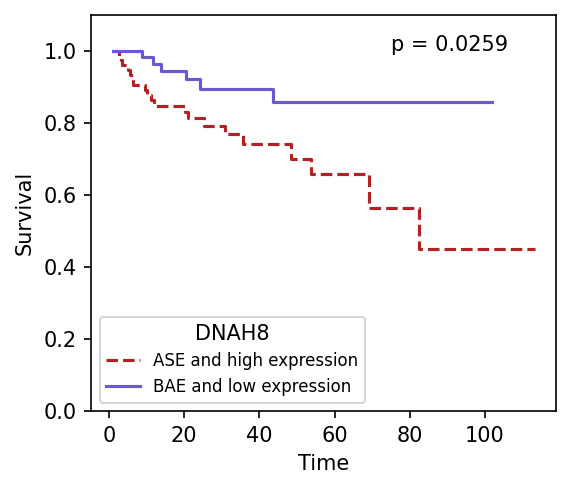

In [110]:
# Test plotting stratified by ASE and expression
ASE_compare_survival("DNAH8", ase_table=ASE, survival_table=clinical, expression_table=tpm, stratify_expression = "ase high", plot=True)

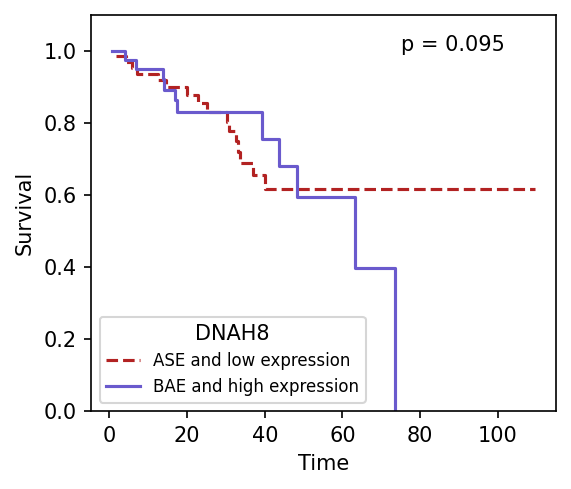

In [111]:
# Test plotting stratified by ASE and expression
ASE_compare_survival("DNAH8", ase_table=ASE, survival_table=clinical, expression_table=tpm, stratify_expression = "ase low", plot=True)

In [ ]:
# Test plotting stratified by ASE

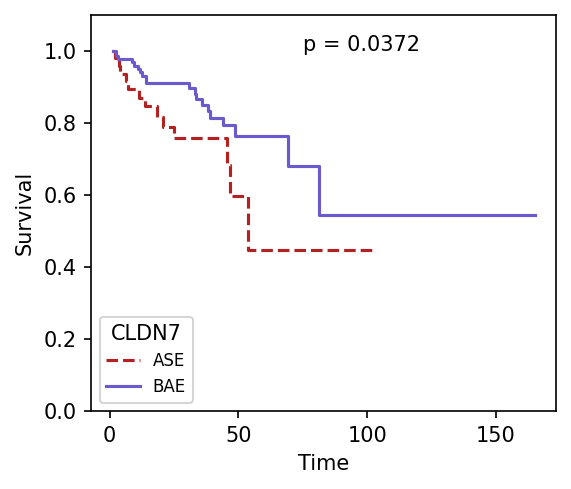

In [115]:
ASE_compare_survival("CLDN7", ase_table=ASE, survival_table=clinical,plot=True)

In [48]:
ASE

,gene,ase,mae,sampleID
0,ZYX,0,0,TCGA-ZG-A9NI
1,ZWINT,0,0,TCGA-ZG-A9NI
2,ZRANB2,0,0,TCGA-ZG-A9NI
3,ZNFX1,0,0,TCGA-ZG-A9NI
4,ZNF84,0,0,TCGA-ZG-A9NI
...,...,...,...,...
1493003,AARS,0,0,TCGA-2A-A8VO
1493004,AAK1,0,0,TCGA-2A-A8VO
1493005,AACS,0,0,TCGA-2A-A8VO
1493006,A4GALT,0,0,TCGA-2A-A8VO
